# Convolutional Neural Network

This notebook creates 2 convolutional neural networks, 1 for aligned images and 1 for unaligned raw images.
Predictions are then based on the network that provides the higher probability.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

seed = 3244
np.random.seed(seed)

h = 50  # height of image
w = 37  # width of image
aligned_h = h
aligned_w = h

num_classes = 7

Using TensorFlow backend.


### Load data used for unaligned model

In [2]:
# Load original data
X = np.load('X_train.npy') # (996, 1850)
y = np.load('y_train.npy') # (996, 1)

# Split into training and validation set
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=seed)

# Load generated data for training set
X_generated_train = np.load('X_train_generated_train.npy')
y_generated_train = np.load('y_train_generated_train.npy')

# Add generated data for training set to original training set
X_train = np.concatenate([X_train, X_generated_train])
y_train_raw = np.concatenate([y_train_raw, y_generated_train])

# Load generated data for validation set
X_generated_test = np.load('X_train_generated_test.npy')
y_generated_test = np.load('y_train_generated_test.npy')

# Concatenate with generated data for training set to get all generated data
X_generated = np.concatenate([X_generated_train, X_generated_test])
y_generated = np.concatenate([y_generated_train, y_generated_test])

# Add all generated data to full training set
X = np.concatenate([X, X_generated])
y = np.concatenate([y, y_generated])

### Load data used for aligned model

In [3]:
# Load original data
X_aligned = np.load('X_train_aligned.npy')
y_aligned = np.load('y_train_aligned.npy')

# Split into training and validation set
X_train_aligned, X_test_aligned, y_train_aligned_raw, y_test_aligned_raw = train_test_split(X_aligned, y_aligned, test_size=0.2, random_state=seed)

# Load generated data for training set
X_generated_train_aligned = np.load('X_train_generated_train_aligned.npy')
y_generated_train_aligned = np.load('y_train_generated_train_aligned.npy')

# Add generated data for training set to original training set
X_train_aligned = np.concatenate([X_train_aligned, X_generated_train_aligned])
y_train_aligned_raw = np.concatenate([y_train_aligned_raw, y_generated_train_aligned])

# Load generated data for validation set
X_generated_test_aligned = np.load('X_train_generated_test_aligned.npy')
y_generated_test_aligned = np.load('y_train_generated_test_aligned.npy')

# Concatenate with generated data for training set to get all generated data
X_generated_aligned = np.concatenate([X_generated_train_aligned, X_generated_test_aligned])
y_generated_aligned = np.concatenate([y_generated_train_aligned, y_generated_test_aligned])

# Add all generated data to full training set
X_aligned = np.concatenate([X_aligned, X_generated_aligned])
y_aligned = np.concatenate([y_aligned, y_generated_aligned])

In [4]:
def shapeData(data, h=h, w=w):
    return data.reshape(data.shape[0], 1, h, w).astype('float32')

def normalize(data):
    return data / 255

In [5]:
X = normalize(shapeData(X))

X_train = normalize(shapeData(X_train))
X_test = normalize(shapeData(X_test))

X_train_aligned = normalize(shapeData(X_train_aligned, h=aligned_h, w=aligned_w))
X_test_aligned = normalize(shapeData(X_test_aligned, h=aligned_h, w=aligned_w))

In [6]:
# One hot encode outputs, this is required for the CNN
y = np_utils.to_categorical(y)

y_train = np_utils.to_categorical(y_train_raw)
y_test = np_utils.to_categorical(y_test_raw)

y_train_aligned = np_utils.to_categorical(y_train_aligned_raw)
y_test_aligned = np_utils.to_categorical(y_test_aligned_raw)

In [7]:
def baseline_model():
    """Baseline model with 1 convolution, 1 max pooling and 2 fully connected layers"""
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
num_filters = 32  # number of convolutional filters to use
pool_size = (2, 2)  # size of pooling area for max pooling
kernel_size = (5, 5)  # convolution kernel size

def model1():
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model2():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, h, w), activation='relu'))
    model.add(Convolution2D(32, 5, 5, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # Note: Keras does automatic shape inference.
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def model3():
    model = Sequential()
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=(1, h, w)))
    model.add(Activation('relu'))
    model.add(Convolution2D(num_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model

def model4():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape=(1, h, w)))
    model.add(Convolution2D(64, 3, 3,  activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation="relu"))
    model.add(MaxPooling2D(strides=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu")) # 4096
    model.add(Dense(num_classes, activation="softmax"))
    
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
    return model

def model5(h=h, w=w):
    """Final configuration of the convolutional neural network that we found to perform the best"""
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, h, w), border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 5, 5, border_mode='valid', activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Train a network based on the raw training data

In [9]:
# model = baseline_model()
# model = model1()
# model = model2()
# model = model3()
# model = model4()
model = model5()

nb_epoch = 40
batch_size = 50

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

y_pred = model.predict_classes(X_test)
f1_score(y_test_raw, y_pred, average='macro')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 46, 33)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 23, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 23, 16)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 19, 12)    51264       dropout_1[0][0]                  
___________________________________________________________________________________________

0.9292760403689071

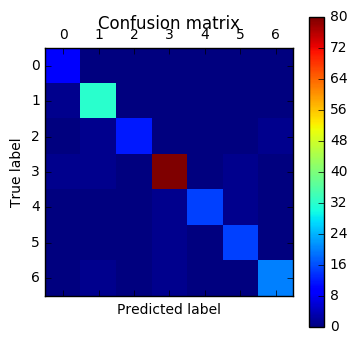

array([[ 9,  0,  0,  0,  0,  0,  0],
       [ 1, 32,  0,  0,  0,  0,  0],
       [ 0,  1, 12,  0,  0,  0,  1],
       [ 1,  1,  0, 80,  0,  1,  0],
       [ 0,  0,  0,  1, 15,  1,  0],
       [ 0,  0,  0,  1,  0, 15,  0],
       [ 0,  1,  0,  1,  0,  0, 20]])

In [10]:
cm = confusion_matrix(y_test_raw, y_pred)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
cm

### Train a network based on the aligned training data

In [11]:
model = model5(h=aligned_h, w=aligned_w)

model.fit(X_train_aligned, y_train_aligned, 
          validation_data=(X_test_aligned, y_test_aligned),
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
          verbose=1)

y_pred_aligned = model.predict_classes(X_test_aligned)
f1_score(y_test_aligned_raw, y_pred_aligned, average='macro')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 46, 46)    832         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 23, 23)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 23, 23)    0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 64, 19, 19)    51264       dropout_3[0][0]                  
___________________________________________________________________________________________

0.96189694376781454

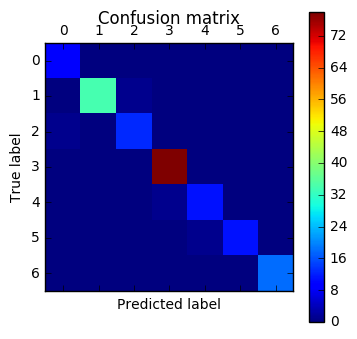

array([[10,  0,  0,  0,  0,  0,  0],
       [ 0, 34,  1,  0,  0,  0,  0],
       [ 1,  0, 13,  0,  0,  0,  0],
       [ 0,  0,  0, 78,  0,  0,  0],
       [ 0,  0,  0,  1, 11,  0,  0],
       [ 0,  0,  0,  0,  1, 11,  0],
       [ 0,  0,  0,  0,  0,  0, 18]])

In [12]:
cm = confusion_matrix(y_test_aligned_raw, y_pred_aligned)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
cm

### Train a full model on the entire given dataset
This includes generated images

In [ ]:
full_model = model5()
full_model.fit(X, y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

### Train a full model on the aligned images derived from the entire given dataset
This includes generated images

In [ ]:
X_aligned = normalize(shapeData(X_aligned, h=aligned_h, w=aligned_w))
y_aligned = np_utils.to_categorical(y_aligned)

full_model_aligned = model5(h=aligned_h, w=aligned_w)
full_model_aligned.fit(X_aligned, y_aligned, nb_epoch=nb_epoch, batch_size=batch_size, verbose=1)

### Use the above 2 models to predict the labels of the given test set
The test set with its images aligned are also used

In [ ]:
X_test_given = normalize(shapeData(np.load('X_test.npy')))
X_test_given_aligned = normalize(shapeData(np.load('X_test_aligned.npy'), h=aligned_h, w=aligned_w))

classes_unaligned = full_model.predict_classes(X_test_given)
classes_aligned = full_model_aligned.predict_classes(X_test_given_aligned)

prob_unaligned = full_model.predict_proba(X_test_given)
prob_aligned = full_model_aligned.predict_proba(X_test_given_aligned)

In [ ]:
print(classes_unaligned)
print(classes_aligned)

In [ ]:
# Retrieved from aligning the images, these are the indices of images where no face was detected
idx_no_face = [25, 85, 104, 106, 125, 131, 180, 202, 211, 233, 238, 244, 279, 283, 304, 309]

updated_classes = classes_aligned.tolist()
updated_prob = prob_aligned.tolist()

# Insert placeholder "None" to indicate that no class was derived for images with no face detected
for i in idx_no_face:
    updated_classes.insert(i, None)
    updated_prob.insert(i, None)

#### Find the final class labels from an ensemble of the 2 models

In [ ]:
def get_max(lst):
    if lst:
        return max(lst), lst.index(max(lst))
    else:
        return None, None

final_classes = []

# Find the predicted class with the highest probability from the 2 model predictions
for idx, (unaligned_prob, aligned_prob) in enumerate(zip(prob_unaligned, updated_prob)):
    unaligned_highest_prob, unaligned_class = get_max(unaligned_prob.tolist())
    aligned_highest_prob, aligned_class = get_max(aligned_prob)
    
    if aligned_highest_prob is None or unaligned_highest_prob > aligned_highest_prob:
        final_classes.append(unaligned_class)
    elif aligned_highest_prob >= unaligned_highest_prob:
        final_classes.append(aligned_class)
    else:
        print(idx, unaligned_highest_prob, unaligned_class, aligned_highest_prob, aligned_class)
        
print(final_classes)

### Save the predictions

In [ ]:
with open("predictions.csv", "w") as f:
    f.write("ImageId,PredictedClass")
    for idx, label in enumerate(final_classes):
        f.write("\n{0},{1}".format(idx, label))